In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

import keras2
from keras2.models import Model

from keras2.layers import concatenate, Dense, Input, Flatten, merge
from keras2.optimizers import Adam
from util import moving_average, dlqr, discretized_system, lqr, make_standup_agent
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

def agent2(a_shape, s_shape):
    actor = branch_actor(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent2(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01,
    )
    return agent

def gain(dt=None):
    m, l, g = env.m, env.l, env.g

    A = np.array([[0, 1], [(3*g)/(2*l), 0]])
    B = np.array([[0], [3/(m*l**2)]])
    Q = np.array([[1, 0], [0, 0.1]])
    R = np.array([[0.001]])
    
    if dt is not None:
        Ad, Bd = discretized_system(A, B, dt)  
        K = dlqr(Ad,Bd,Q,R)[0]
    else:
        K = lqr(A,B,Q,R)[0]
    
    return K

In [4]:
NN = branch_actor((2,),(2,))

In [5]:
# 学習データの用意
tau = 0.1
action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
dt = tau / action_repetition
print(dt)
K = gain(dt)
x_train = []
y_train = []
for i in range(30000):
    x_train.append([np.random.randn(2,) / 16.])
    y_train.append([np.dot(K, x_train[-1][0]), tau])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape, y_train.shape)

0.005
(30000, 1, 2) (30000, 2)


In [6]:
# learn
NN.compile(loss='mean_squared_error',optimizer='adam')
history = NN.fit(x_train, y_train, batch_size=128, epochs=50, verbose=0)

In [7]:
# save
NN.save_weights('./saved_agent/tmp.h5')

In [14]:
a = agent2((2,), (2,))
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
a.actor = make_standup_agent(a.actor, 0.001, env)

NN: -2.47389817237854, opt: -2.2836737963903486
NN: -4.2602128982543945, opt: -4.104222765594486
NN: -0.8245062828063965, opt: -0.7587586414410763
NN: -1.364851951599121, opt: -1.2495811877945031
NN: -3.013172149658203, opt: -2.8101772953914868
NN: 3.991830348968506, opt: 3.7820239895501273
NN: -6.943550109863281, opt: -6.593898618475005
NN: -4.057987213134766, opt: -3.8839248460246387
NN: -0.6300572156906128, opt: -0.5819241464188408
NN: 1.8358503580093384, opt: 1.6517191933139266
NN: -0.3535366654396057, opt: -0.3325344841622412
NN: -2.8934741020202637, opt: -2.69285183999313
NN: 4.685057640075684, opt: 4.549308292168579
NN: 0.44215214252471924, opt: 0.3823911952346609
NN: 3.7104198932647705, opt: 3.4850189890992143
NN: 3.9940152168273926, opt: 3.7831110883526318
NN: -0.5692766308784485, opt: -0.5274807352174186
NN: -1.7500743865966797, opt: -1.6037830808517104
NN: -2.113658905029297, opt: -1.9430696079063663
NN: 0.1718747913837433, opt: 0.13954496376590253
NN: -9.776710510253906, op

NN: -2.898174285888672, opt: -2.6962495294579902
NN: 0.47388923168182373, opt: 0.4112378189550757
NN: -4.020838737487793, opt: -3.844249099973907
NN: -7.028985500335693, opt: -6.693653624099191
NN: 0.1555059552192688, opt: 0.12386002832321896
NN: -0.22144150733947754, opt: -0.214321553301255
NN: -0.20004746317863464, opt: -0.19594299152636763
NN: 1.8918143510818481, opt: 1.70474673124514
NN: -3.93977689743042, opt: -3.7568036204600888
NN: 3.0296051502227783, opt: 2.792168078719976
NN: -2.1442463397979736, opt: -1.973234077019277
NN: -1.2746869325637817, opt: -1.1667916540842924
NN: -2.1674513816833496, opt: -1.9935655204749878
NN: 1.7828434705734253, opt: 1.602014258068253
NN: 4.731242656707764, opt: 4.6028769547057
NN: 1.9154963493347168, opt: 1.727698281471839
NN: 0.8503042459487915, opt: 0.7493961065031526
NN: -3.8177428245544434, opt: -3.628174719127034
NN: -0.29130393266677856, opt: -0.2768554510614089
NN: -1.8619701862335205, opt: -1.7058634725567976
NN: -3.6834158897399902, opt:

NN: -7.408552169799805, opt: -7.1637190115245595
NN: -0.9635179042816162, opt: -0.8844431010926392
NN: -1.9852547645568848, opt: -1.8233407368609602
NN: -2.1054906845092773, opt: -1.934773111855662
NN: 2.6203866004943848, opt: 2.395378410285407
NN: 1.8128044605255127, opt: 1.6299149440793657
NN: 1.223422884941101, opt: 1.0875404098400268
NN: 2.0189390182495117, opt: 1.8228915664823147
NN: -1.1836649179458618, opt: -1.0843039496820748
NN: 2.936999797821045, opt: 2.7036585113896994
NN: 1.04203200340271, opt: 0.9236101300811455
NN: -2.005838394165039, opt: -1.8429038034364553
NN: 0.8482446670532227, opt: 0.7485803215706703
NN: 3.494863748550415, opt: 3.2620480783667394
NN: 0.34394946694374084, opt: 0.29433173242707966
NN: 6.820001125335693, opt: 6.331175476770342
NN: 0.9008978605270386, opt: 0.7965437574543357
NN: 2.491342782974243, opt: 2.2697466446830545
NN: -2.415069341659546, opt: -2.227390184252496
NN: 2.660048484802246, opt: 2.43296512646985
NN: -7.688567638397217, opt: -7.502173986

NN: 3.1245288848876953, opt: 2.8899148928769733
NN: -2.940333366394043, opt: -2.7364456605047764
NN: 3.0590317249298096, opt: 2.8253158561524927
NN: 6.305239200592041, opt: 6.014709845250821
NN: -0.7370492219924927, opt: -0.6797581818483822
NN: 0.6270548105239868, opt: 0.5495676274857169
NN: -4.106734752655029, opt: -3.936553299967743
NN: 1.7896537780761719, opt: 1.6113509466972125
NN: 3.3049871921539307, opt: 3.0683062413901894
NN: 0.022101961076259613, opt: 0.004429881723748821
NN: -8.732436180114746, opt: -8.10319153698961
NN: -2.2199363708496094, opt: -2.0437570922031725
NN: -9.427474021911621, opt: -8.892863753747967
NN: -2.5438318252563477, opt: -2.3528838581597347
NN: -2.409473419189453, opt: -2.2215463877492563
NN: 0.018792130053043365, opt: 0.0013406563223458887
NN: 2.705498695373535, opt: 2.4761392415935286
NN: 5.051035404205322, opt: 4.978790489820146
NN: 8.955663681030273, opt: 8.564895186880582
NN: 0.14609234035015106, opt: 0.11582938214899301
NN: -1.4658945798873901, opt:

NN: 0.11419140547513962, opt: 0.0865581856686779
NN: 1.9044582843780518, opt: 1.7168105665195181
NN: -3.1610641479492188, opt: -2.956133674291497
NN: -0.9665465354919434, opt: -0.8857035082652148
NN: 1.131212592124939, opt: 1.0052092068062264
NN: -6.865879058837891, opt: -6.506402323277298
NN: 1.5016710758209229, opt: 1.3431018181352257
NN: -6.807538032531738, opt: -6.4431238813707115
NN: -0.183039128780365, opt: -0.17904867758793097
NN: 4.348422527313232, opt: 4.170182874138652
NN: 1.092610239982605, opt: 0.9701875737958368
NN: -6.123503684997559, opt: -5.743868867376625
NN: -2.85117244720459, opt: -2.6505088132601307
NN: -1.13902747631073, opt: -1.0422697486711978
NN: 2.127162218093872, opt: 1.9250173799931654
NN: 0.7896893620491028, opt: 0.6953024358297158
NN: -3.4234676361083984, opt: -3.2199897812508973
NN: 3.0690016746520996, opt: 2.8332453699152516
NN: 1.1352598667144775, opt: 1.0107634291166065
NN: 4.461520195007324, opt: 4.295148128148042
NN: -4.317887306213379, opt: -4.186529

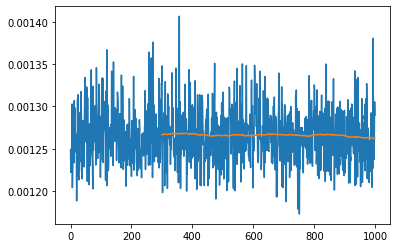

In [15]:
# validation
taus = []
for i in range(1000):
    x = np.random.randn(2,) / 10.
    a_agent, tau = a.forward(x)
    taus.append(tau)
    print(f'NN: {a_agent}, opt: {np.dot(K, x)}')
plt.plot(range(len(taus)), taus)
plt.plot(range(300, len(taus)), moving_average(taus, 300))
plt.show()

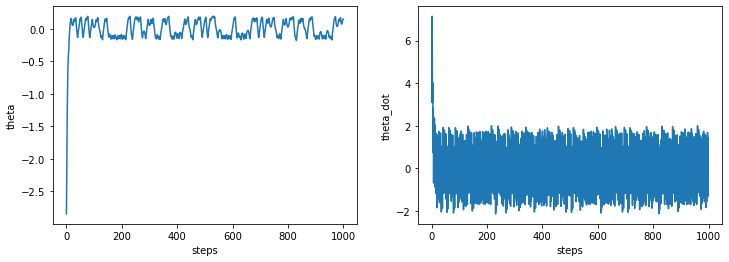

In [16]:
# 実環境テスト

def rad_clip(th):
    r = abs(th)
    while r > np.pi:
        r -= 2*np.pi
    th = np.sign(th) * r
    return th

env.reset()
states = []
taus = []
for i in range(1000):
    x = env.state
    states.append([rad_clip(x[0]), x[1]])
    a_agent, tau = a.forward(x)
    tau = 0.1
    taus.append(tau)
    action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        _,_,_,_ = env.step(np.array([a_agent]), dt, tau)
states = np.array(states)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.xlabel('steps')
plt.ylabel('theta')
plt.plot(range(states.shape[0]), states[:,0])
plt.subplot(1,2,2)
plt.xlabel('steps')
plt.ylabel('theta_dot')
plt.plot(range(states.shape[0]), states[:,1])
plt.show()

In [12]:
print(taus)

[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001